In [1]:
import time
import os
import glob
from collections import Counter

from IPython.display import clear_output

import numpy as np
import torch
from torch import nn, optim, cuda
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split, Dataset, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
device = 'cpu'
if cuda.is_available():
    device_name = cuda.get_device_name(0)
    memory = cuda.get_device_properties(0).total_memory / (1024 ** 3)
    print(f"Device {device_name} has {memory} GB of memory")
    device = torch.device('cuda')
else:
    raise Exception("Cuda isn't available")
device

Device NVIDIA GeForce RTX 3060 Ti has 7.9993896484375 GB of memory


device(type='cuda')

Create all paths for save stats


In [4]:
runs_dir = "runs"
os.makedirs(runs_dir, exist_ok=True)
existing_runs = [d for d in os.listdir(
    runs_dir) if os.path.isdir(os.path.join(runs_dir, d))]


if existing_runs:
    max_index = max([int(d.split("run")[1]) for d in existing_runs])
    new_run_index = max_index + 1
else:
    new_run_index = 1

current_run_dir = os.path.join(runs_dir, f"run{new_run_index}")
os.makedirs(current_run_dir, exist_ok=True)

train_stats_file = os.path.join(current_run_dir, "train_stats.txt")
test_stats_file = os.path.join(current_run_dir, "test_stats.txt")
best_model_weights_file = os.path.join(current_run_dir, "best.pth")
plot_file = os.path.join(current_run_dir, "plot.png")

Func for build loss plot and metric plot


In [5]:
def build_figures_with_same_x(figures, x_vals, plot_file="plot.png"):
    n = len(figures)
    fig, axs = plt.subplots(n, 1)

    for idx, (fig_key, fig_value) in enumerate(figures.items()):
        for (plot_key, plot_value) in fig_value.items():
            # Проверяем, что длины x_vals и plot_value совпадают
            if len(x_vals) != len(plot_value):
                min_length = min(len(x_vals), len(plot_value))
                x_vals = x_vals[:min_length]  # Обрезаем x_vals
                plot_value = plot_value[:min_length]  # Обрезаем plot_value

            # Строим график
            axs[idx].plot(x_vals, plot_value, label=plot_key)

        axs[idx].legend()
        axs[idx].grid(True)
        axs[idx].set_xticks(x_vals[::2])
        axs[idx].set_xticklabels(x_vals[::2], rotation=90)
        axs[idx].set_title(fig_key)

    plt.tight_layout()
    plt.savefig(plot_file)
    plt.show()

In [6]:
BS = 128
VAL_SPLIT = 0.15
RESIZE = 224
NUM_CLASSES = 42

In [7]:
original_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([RESIZE, RESIZE], antialias=False),
    transforms.CenterCrop(RESIZE),
])


visualize_train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([RESIZE, RESIZE], antialias=False),
    transforms.CenterCrop(RESIZE),

    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])


train_transform = transforms.Compose([
    # transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.ToTensor(),
    transforms.Resize([RESIZE, RESIZE], antialias=False),
    transforms.CenterCrop(RESIZE),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])


val_transform = transforms.Compose([
    # transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.ToTensor(),
    transforms.Resize([RESIZE, RESIZE], antialias=False),
    transforms.CenterCrop(RESIZE),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Create custom TestDataset due to we haven't folders with classname in test dir


In [8]:
class TestDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.file_paths = glob.glob(os.path.join(self.folder_path, '*.jpg'))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_path

In [9]:
train_val_dataset = datasets.ImageFolder(root='./dataset/train/simpsons_dataset', transform=train_transform)

subset_size = int(1.0 * len(train_val_dataset))
remaining_size = len(train_val_dataset) - subset_size
train_val_dataset, remaining_dataset = random_split(train_val_dataset, [subset_size, remaining_size])

train_size = int((1 - VAL_SPLIT) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
test_dataset = TestDataset(folder_path="./dataset/testset/testset", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

Block for compare original images and augmented


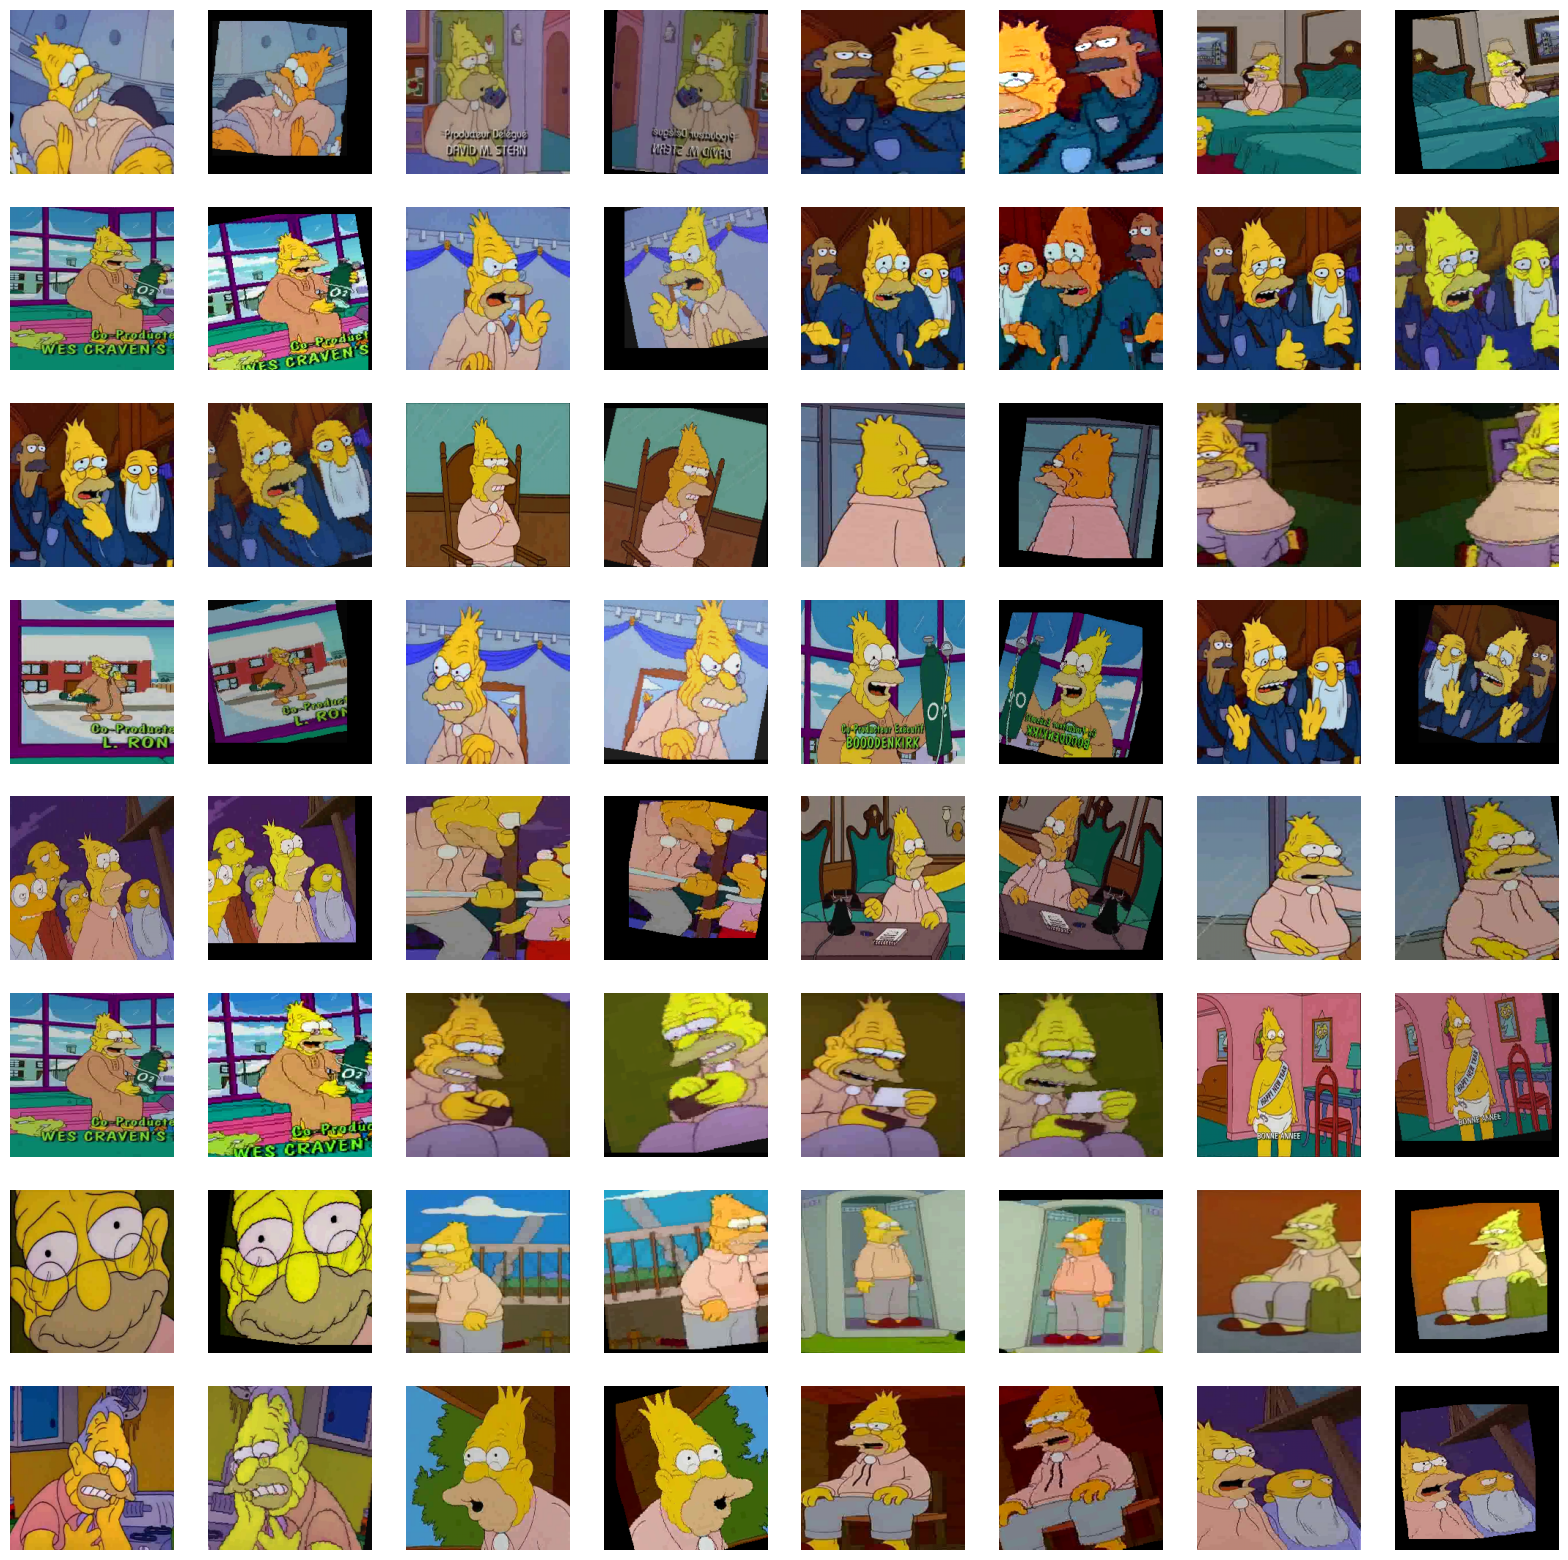

In [10]:
original_dataset = datasets.ImageFolder(root='./dataset/train/simpsons_dataset', transform=original_transform)
visualize_train_dataset = datasets.ImageFolder(root='./dataset/train/simpsons_dataset', transform=visualize_train_transform)

visualise_train_loader = DataLoader(visualize_train_dataset, batch_size=BS, shuffle=False)
original_train_loader = DataLoader(original_dataset, batch_size=BS, shuffle=False)


def show_original_and_augmented(original_images, augmented_images):
    fig, axes = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            axes[i, j*2].imshow(original_images[i*4 + j].permute(1, 2, 0))
            axes[i, j*2].axis('off')
            axes[i, j*2+1].imshow(augmented_images[i*4 + j].permute(1, 2, 0))
            axes[i, j*2+1].axis('off')
    plt.show()


original_batch, augmented_batch = next(zip(original_train_loader, visualise_train_loader))
show_original_and_augmented(original_batch[0], augmented_batch[0])

In [11]:
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")

Train Dataset Length: 17793
Validation Dataset Length: 3140
Test Dataset Length: 991


In [12]:
try:
    if model:
        model.zero_grad()
        del model
        torch.cuda.empty_cache()
        print('model has been deleted')
except:
    print('model doesnt exist')

model doesnt exist


In [13]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.resnet18 = models.resnet18(
            weights=models.ResNet18_Weights.DEFAULT)
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_features, num_classes)
        self.resnet18 = self.resnet18

    def forward(self, x):
        return self.resnet18(x)


model = CustomResNet18(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

In [15]:
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
# num_epochs = 100
num_epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

In [16]:
x_vals = []
train_losses = []
val_losses = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

best_val_loss = float('inf')
best_train_loss = float('inf')
best_val_accuracy = 0.0
best_epoch = 0

In [17]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    running_loss = 0.0
    i = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"\r Train batch {batch_idx}/{len(train_loader)}", end='', flush=True)
        i += 1
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)


def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_running_loss = 0.0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            print(f"\r Val batch {
                  batch_idx}/{len(val_loader)}", end='', flush=True)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)

            predicted = torch.argmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        epoch_val_loss = val_running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(
            true_labels, predicted_labels, average='weighted')
        recall = recall_score(
            true_labels, predicted_labels, average='weighted')
        f1 = f1_score(true_labels, predicted_labels, average='weighted')

        print(f"Acc: {accuracy}, Precision: {precision}, Recall: {recall}")
    return (epoch_val_loss, accuracy, precision, recall, f1)

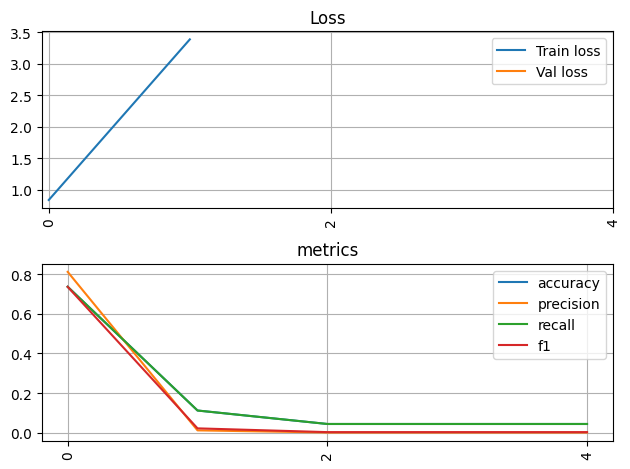

[0.8404176475746291, 3.3900548922164098, nan, nan, nan]
[nan, 3.2212102699279783, nan, nan, nan]
f1: 0.003859511528448877
Epoch: 5 / 10
 Train batch 25/140

KeyboardInterrupt: 

In [18]:
start = time.time()
for epoch in range(num_epochs):
    print(f'\rEpoch: {epoch} / {num_epochs}')
    x_vals.append(epoch)

    epoch_train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"\nTrain loss: {epoch_train_loss}")
    train_losses.append(epoch_train_loss)

    epoch_val_loss, accuracy, precision, recall, f1 = val_epoch(model, val_loader, criterion, device)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_train_loss = epoch_train_loss
        best_val_f1 = f1
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_weights_file)
        dur = time.time() - start
        with open(train_stats_file, "a") as f:
            f.write(f"Epoch {epoch + 1} / {num_epochs}: Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}, Val f1: {f1} Dur: {dur} Dur/Epoch: {dur / epoch if epoch != 0 else 0}\n")
    elif epoch > best_epoch + 4 and epoch_train_loss < best_train_loss:
        print(f"\nTraining has stopped at {epoch} / {num_epochs} cuz val loss didn't decrease for {4} epochs")
        break


    clear_output(wait=True)
    build_figures_with_same_x(
        {
            'Loss': {
                'Train loss': train_losses,
                'Val loss': val_losses
            },
            'metrics': {
                'accuracy': accuracy_list,
                'precision': precision_list,
                'recall': recall_list,
                'f1': f1_list
            }
        },
        x_vals,
        plot_file=current_run_dir + "plot.png")
    print(train_losses)
    print(val_losses)
    print(f"f1: {f1}")


In [ ]:
path_to_dataset = r"./dataset/train/simpsons_dataset"
classes = [folder for folder in os.listdir(path_to_dataset) if os.path.isdir(os.path.join(path_to_dataset, folder))]
print(classes)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
import matplotlib.pyplot as plt
import torch
import numpy as np

def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    mean = np.array(mean)[None, :, None, None]
    std = np.array(std)[None, :, None, None]
    image = image * std + mean
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    return image

def show_8_images(images, labels, predictions):
    fig, axes = plt.subplots(1, 8, figsize=(24, 6))
    for idx, img in enumerate(images):
        img = img[0]
        img = img.transpose((1, 2, 0))
        axes[idx].imshow(img)
        axes[idx].set_title(f"P:{classes[predictions[idx]]}\nR:{classes[labels[idx]]}")
        axes[idx].axis('off')
    plt.show()

def test(model, test_loader, criterion, device, get_stat_batches=1):
    model.eval()
    test_running_loss = 0.0
    true_labels = []
    predicted_labels = []

    images_to_display = []
    labels_to_display = []
    predictions_to_display = []

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            if get_stat_batches != 0 and batch_idx == get_stat_batches:
                break

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

            if get_stat_batches == 0:
                continue

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for img, pred, label in zip(images, predicted, true_labels):
                denormalized_img = denormalize(img.cpu().numpy())
                images_to_display.append(denormalized_img)
                labels_to_display.append(label)
                predictions_to_display.append(pred)

                if len(images_to_display) == 8:
                    show_8_images(images_to_display, labels_to_display, predictions_to_display)
                    images_to_display = []
                    labels_to_display = []
                    predictions_to_display = []

        if get_stat_batches == 0:
            return predicted_labels

        test_loss = test_running_loss / len(test_loader)

        accuracy = accuracy_score(all_labels, all_preds)
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')

        print(f'Accuracy: {accuracy:.4f}')
        print(f'F1 (Macro): {f1_macro:.4f}')
        print(f'F1 (Weighted): {f1_weighted:.4f}')

        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds))

    return (test_loss, accuracy, f1_macro, f1_weighted, predicted_labels)

In [ ]:
# test_loss, accuracy, f1_macro, f1_weighted, predicted_labels = test(model, val_loader, criterion, device)

# metrics = ['Accuracy', 'F1 (Macro)', 'F1 (Weighted)']
# values = [accuracy, f1_macro, f1_weighted]

# plt.figure(figsize=(10, 6))
# plt.barh(metrics, values, color='skyblue')
# plt.xlabel('Score')
# plt.title('Classification Metrics')
# plt.show()

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    predicted_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            predicted_labels.extend(predicted.cpu().numpy())
    return predicted_labels

In [ ]:
predicted_labels = predict(model, test_loader, device)
print(len(predicted_labels))
print(predicted_labels)

In [ ]:
import pandas as pd


test_filenames = []
for i, label in enumerate(predicted_labels):
    test_filenames.append(f"img{i}.jpg")

my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': [classes[label] for label in predicted_labels]})
my_submit.to_csv('submission.csv', index=False)
my_submit.head(20)